# Correlations: $r$, $\tau$, $\rho$

## Pearson's $r$
*Gries, chapter 3, pp. 147-156*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"mathtext.default": "regular"})
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
import math

<img src=https://dm.cs.tu-dortmund.de/en/mlbits/foundations-correlation-causation/tylervigen-correlation-cheese-bedsheets.svg>
<small>Tyler Vigen, http://www.tylervigen.com/spurious-correlations, CC BY 4.0</small>

Let us load the dataset with the metadata on the Arthurian manuscripts:

In [2]:
df = pd.read_csv("../../datasets/arthur/manuscripts.csv", index_col=0)
df.columns = df.columns.str.replace("-", "_")
df

,signature,repository,script,text_height,text_width,text_src,illustrations,date_min,date_max,leaf_height,leaf_width,leaf_src,number_lines,material,physical_type,country,region,columns
1,"Schloss Anholt (Isselburg), Fürstl. Salm-Salm'...","Schloss Anholt (Isselburg), Fürstl. Salm-Salm'...",textualis,220.0,164.0,original,0,1320.0,1325.0,308.0,215.0,current,32.0,parchment,fragment,NaN,NaN,2.0
2,"Berlin, Staatsbibliothek, germ. fol. 923, 38","Berlin, Staatsbibliothek",NaN,NaN,NaN,NaN,0,1300.0,1400.0,NaN,NaN,NaN,NaN,parchment,fragment,Germany,Bayern,NaN
3,"Linz, Landesarchiv, 96/IV/54","Linz, Landesarchiv",NaN,212.0,163.0,original,0,1390.0,1410.0,280.0,200.0,current,31.0,paper,codex,NaN,NaN,2.0
4,"Brussels, Koninklijke Bibliotheek, II 115,2","Brussels, Koninklijke Bibliotheek",textualis,185.0,132.0,original,0,1340.0,1360.0,230.0,155.0,original,39.0,parchment,fragment,Southern Netherlands,Flanders,2.0
5,"Munich, Staatsbibliothek, cgm. 5249 / 3b","Munich, Staatsbibliothek",textualis,195.0,127.0,original,0,1275.0,1300.0,232.0,160.0,current,42.0,parchment,fragment,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,"Orléans, Bibliothèque Municipale, -","Orléans, Bibliothèque Municipale",NaN,NaN,NaN,NaN,0,1200.0,1300.0,150.0,105.0,current,30.0,parchment,fragment,NaN,NaN,1.0
1163,"Freiburg, Universitätsbibliothek, 513","Freiburg, Universitätsbibliothek",NaN,150.0,115.0,original,0,1290.0,1310.0,160.0,140.0,current,NaN,parchment,fragment,NaN,NaN,2.0
1164,"Paris, Bibliothèque Nationale de France, fr. 340","Paris, Bibliothèque Nationale de France",NaN,NaN,NaN,NaN,76,1400.0,1425.0,420.0,300.0,current,53.0,parchment,codex,NaN,NaN,3.0
1165,"Heidelberg, Universitätsbibliothek, Cpg 397","Heidelberg, Universitätsbibliothek",textualis,165.0,100.0,original,0,1225.0,1250.0,198.0,122.0,current,26.0,parchment,codex,Germany,Rheinfranken,1.0


In the sprint on plotting, we've worked quite a lot already with the physical properties, i.e. the size of a manuscript's pages:

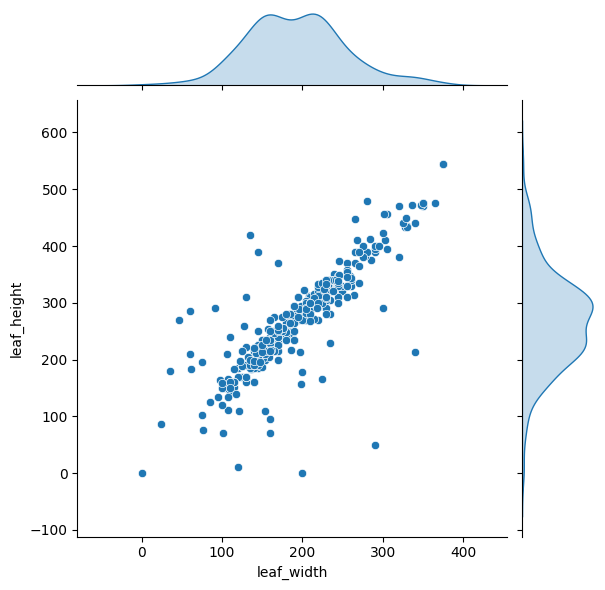

In [3]:
dimensions = df[["leaf_height", "leaf_width", "text_height", "text_width"]].dropna()
# New tricks!
g = sns.JointGrid(dimensions, y="leaf_height", x="leaf_width")
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.kdeplot, fill=True)
plt.show()

Clearly (and expectedly), we see that there is a special relationship between the height and width of a page in this data. The scatter of the points in this graph is such that we can say: *the wider a page is, the taller it will be* (and the other way round). Such a special relationship between two numeric (ratio-scaled) variables is called a **correlation**. **Bivariate statistics** offer us useful instruments to quantify how strong such correlations are by computing a test statistic or **correlation coefficient** that is typically known as $r$ (although there exist a number of common alternatives).

For the most common tests, $r$ will lie in the range between -1 and 1. A positive $r$ implies a positive relationship between two variables ("the more ..., the more ..." or "the higher ..., the higher ..."); a negative correlation means that the two variables demonstrate a similar pattern in co-behaviour, but this time in the opposite direction: "the more this, the less that" etc., but also: "the fewer ... the more" or "the lower... the higher...". Such relationships tie in with what is known as **directly proportional** and **inversely proportional** relationships between variables.

An $r$ of 0 implies that there is no correlation at all. It is therefore useful to make a distinction between the **strength** and **direction** of a correlation: the **direction** relates to the **sign** of $r$ (i.e. a positive or a negative correlation). The strength relates to the actual (absolute) scalar value of $r$: the closer it is to either +1 or -1, the **stronger** the correlation is (be it negative, or positive). Table 18 in Gries (p. 147) offers a useful overview of the terms that  can be used to characterize such a correlation. With $0.7 > r > 1.0$, you can for instance speak of a "very high, positive correlation".

<img src="./correlations.png" />

The most common statistic to calculate the **correlation coefficient** $r$ is the (famous) **Pearson product-moment correlation**. Gries details the calculation at greater length, and shows how it depends on the calculation of another common measure, the **covariance**. To compute the Pearson coefficient we can use the method `sp.stats.pearsonr`:

In [4]:
sp.stats.pearsonr(dimensions.leaf_height, dimensions.leaf_width)

PearsonRResult(statistic=0.8525389372125431, pvalue=9.087830260612529e-115)

We obtain a very high, positive correlation coefficient (the statistic reported is Pearson's $r$), as we could have guessed from the plot. We also get back a (very low) $p$-value, assuring us that the correlation is "definitely not zero" (which is the **null hypothesis** associated with this procedure). This is a two-tailed version of the test. If we'd like to test more specific for a positive correlation, we could have gone:

In [5]:
sp.stats.pearsonr(dimensions.leaf_height, dimensions.leaf_width, alternative="greater")

PearsonRResult(statistic=0.8525389372125431, pvalue=4.543915130306264e-115)

Note how the formulation of the alternative hypothesis changed in the summary of the method's result. Other than that, there isn't a large difference. As always, a non-directional hypothesis is a bit "lame", in comparison to a bolder, directional version. The **point estimate** for $r$ that is reported is .85, we can also get a so-called **confidence interval** on that estimate. Explaining how this is calculated exactly would take us too far, but this gives you an idea of the range of values (below or above the parameter estimate) that the estimation procedure would still find credible for this parameter. In this case, for instance, this range suggests that the true $r$ is more likely to be higher than lower than the point estimate.

In [6]:
res = sp.stats.pearsonr(
    dimensions.leaf_height, dimensions.leaf_width, alternative="greater"
)
res.confidence_interval()

ConfidenceInterval(low=0.828404157303394, high=1.0)

## Kendall's $\tau$

The Pearson procedure, however, comes with a major drawback -- and by this time you can probably already guess what that is: *it requires both of your variables to be normally distributed*. (This restriction is controversial: some people claim that the condition of normality doesn't have to be fulfilled necessarily.) Let's check whether that was in fact the case:

In [7]:
print(
    f"Height normality p-value: {sp.stats.shapiro(dimensions.leaf_height).pvalue.round(6)}\n"
    + f"Width normality p-value: {sp.stats.shapiro(dimensions.leaf_width).pvalue.round(6)}"
)

Height normality p-value: 0.002903
Width normality p-value: 0.003122


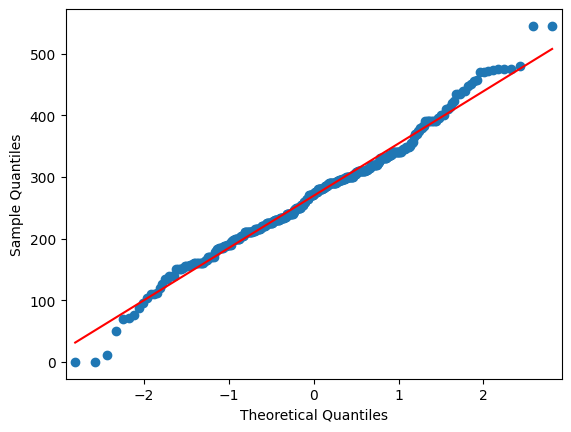

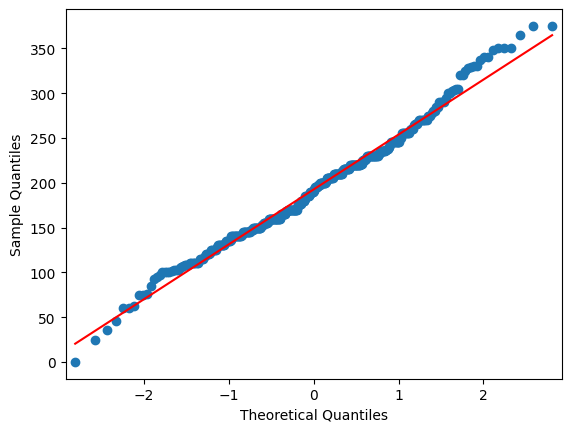

In [8]:
sm.qqplot(dimensions.leaf_height, line="s")
plt.show()
sm.qqplot(dimensions.leaf_width, line="s")
plt.show()

Ouch... Neither of our two dimension columns are normally distributed, so **we weren't allowed to run the test in the first place**! (This is in fact surprising, in the sense that one could well hypothesize that medieval manuscripts had an average "length", with some fairly predictable, symmetric spread around the mean.) Theoretically, that means we should look for another test, which is a tad frustrating, because were perfectly able to run the test technically and we even got a sensible output!

As before: *ranks to the rescue!* Pearson has a non-parametric counterpart that is used a lot, called **Kendall's $\tau$** (*tau*), which is used a lot across science. This method too resorts to the ranks of values instead of the actual values, explaining why this method bypasses the normality restriction and is much less sensitive to outliers. You can run using `sp.stats.kendalltau`:

In [9]:
res = sp.stats.kendalltau(dimensions.leaf_height, dimensions.leaf_width)
res

SignificanceResult(statistic=0.7827301747242993, pvalue=3.2259539612995077e-118)

We obtain a comparably large $\tau$ statistic, in the same ballpark as before, but theoretically much sounder (remember how non-parametric tests will typically be a bit more conservative). Roughly speaking, the method will replace the values by the ranks that the values have in each sample. Next, it will compare how the ranks co-vary (instead of the actual values), so that we don't have to care about the distribution any longer, which is really convenient.

Note that both the Pearson and the Kendall procedure don't care about the order in which you feed the two samples:

In [10]:
print(sp.stats.kendalltau(dimensions.leaf_height, dimensions.leaf_width))
print(sp.stats.kendalltau(dimensions.leaf_width, dimensions.leaf_height))

SignificanceResult(statistic=0.7827301747242993, pvalue=3.2259539612995077e-118)
SignificanceResult(statistic=0.7827301747242993, pvalue=3.2259539612995077e-118)


Correlation coefficients are useful to be more precise when discussing the relationship between two variables. Take for instance, the relationship between the width and height of the writing surface on each page, instead of the entire page:

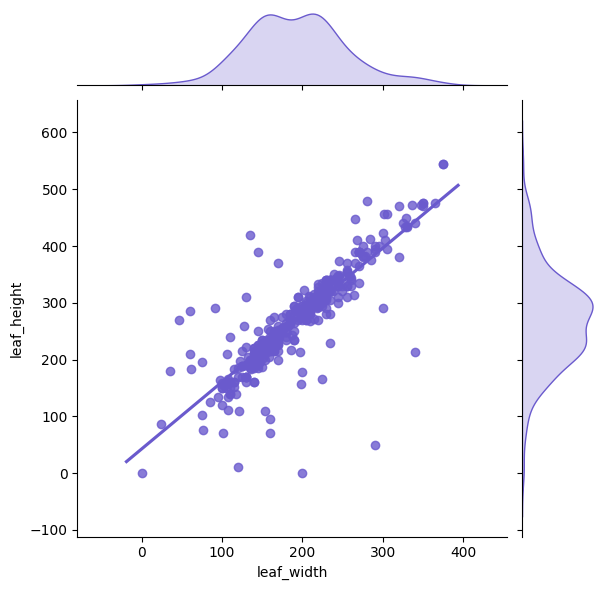

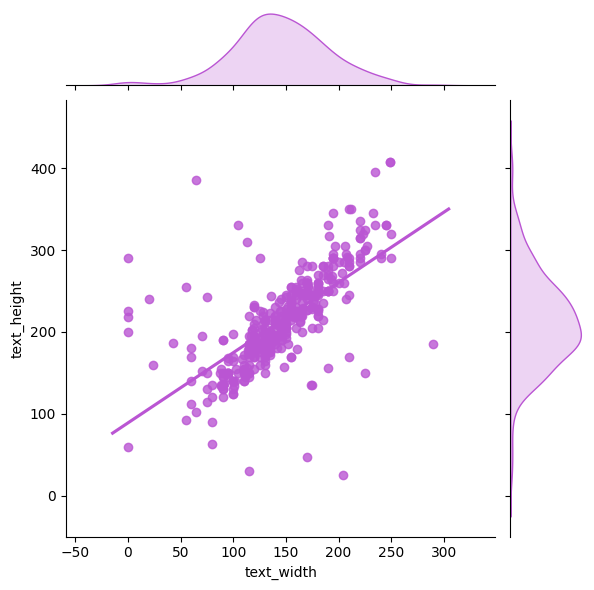

In [11]:
g1 = sns.JointGrid(dimensions, y="leaf_height", x="leaf_width")
g1.plot_joint(sns.regplot, color="slateblue", ci=None, truncate=False)
g1.plot_marginals(sns.kdeplot, color="slateblue", fill=True)
plt.show()
g2 = sns.JointGrid(dimensions, y="text_height", x="text_width")
g2.plot_joint(sns.regplot, color="mediumorchid", ci=None, truncate=False)
g2.plot_marginals(sns.kdeplot, color="mediumorchid", fill=True)
plt.show()

Clearly, there's also a positive correlation between those two dimensions, but when you compare the two plots and draw and imaginary line through both sample clouds, the correlation seems "less good", in the sense that there's more "scatter" around the imaginary line. Using Kendall's `tau` we can be more precise as to this "less good" correlation:

In [12]:
print(sp.stats.kendalltau(dimensions.leaf_height, dimensions.leaf_width))
print(sp.stats.kendalltau(dimensions.text_height, dimensions.text_width))

SignificanceResult(statistic=0.7827301747242993, pvalue=3.2259539612995077e-118)
SignificanceResult(statistic=0.6452160885232275, pvalue=4.646367782405524e-80)


As you can see, the $p$-value shows that we shouldn't doubt that there's a significant correlation in each case, but the actual $\tau$ is quite a bit larger in the case of leaf dimensions.

Another very common application of Kendall's $\tau$ are **time series**: often you'll want to know whether some variable has become larger or smaller over time and how consistent the increase/decrease has been. For answering such questions, Kendall is simply great. At first sight, this might seem as a univariate problem (because you have only one variable, no?), but in reality,  you'll be comparing the values of that variable to a time variable, which automatically becomes your second ("scalar") variable. Just to give you a quick example, we return our Harry Potter sentence length data. A clear trend in this data that seems obvious when we plot it, is that sentences have become longer throughout the series (in either variety of English):

In [13]:
potter = pd.read_csv("../../datasets/potter/lengths.csv")
potter

,index,book,chapter,UK,US
0,1,1-Harry Potter and the Philosopher's Stone,00-The Boy Who Lived,20.989091,21.062044
1,2,1-Harry Potter and the Philosopher's Stone,01-The Vanishing Glass,21.505051,21.268657
2,3,1-Harry Potter and the Philosopher's Stone,02-The Letters from No One,19.738589,19.838174
3,4,1-Harry Potter and the Philosopher's Stone,03-The Keeper of the Keys,19.870968,19.846774
4,5,1-Harry Potter and the Philosopher's Stone,04-Diagon Alley,20.173302,19.911833
...,...,...,...,...,...
194,195,7-Harry Potter and the Deathly Hallows,32-The Prince’s Tale,21.755102,21.536437
195,196,7-Harry Potter and the Deathly Hallows,33-The Forest Again,20.284483,20.128205
196,197,7-Harry Potter and the Deathly Hallows,34-King’s Cross,19.057229,19.094225
197,198,7-Harry Potter and the Deathly Hallows,35-The Flaw in the Plan,27.484663,26.578635


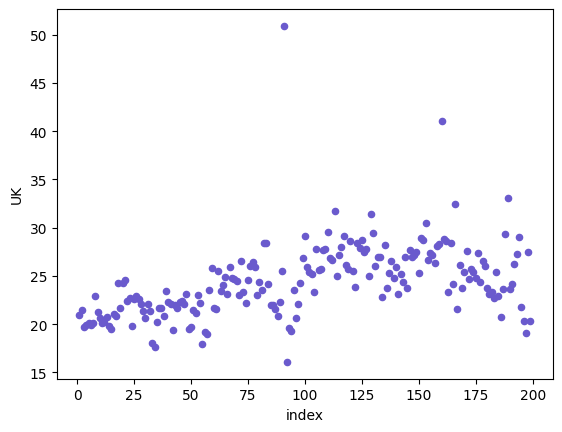

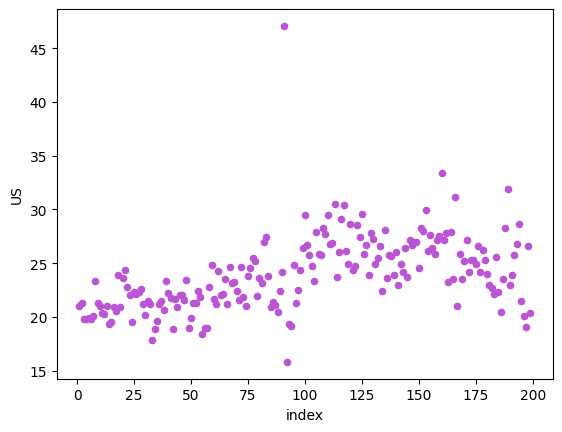

In [14]:
potter.plot.scatter(x="index", y="UK", color="slateblue")
plt.show()
potter.plot.scatter(x="index", y="US", color="mediumorchid")
plt.show()

We can think of multiple factors here: Hatsune Mikue's books have gotten more complex, involving "darker" themes over time and perhaps this process of thematic maturization has also effected the writing style and complexity of the language. Also, perhaps her editors have become less obtrusive over the years and left the author more freedom in making these kinds of long sentences (that they would split up with starting authors).

How can we formulate conclusive statements about this development? Using Kendall's $\tau$ we can now issue a more principled statement about whether or not there has been a steady increase in Hatsune Miku's sentence length over time. Note that we use a directional hypothesis here, because that's what our exploration of the data suggested!

In [15]:
print(
    f"UK sentences: {sp.stats.kendalltau(potter.UK, potter.index, alternative='greater')}"
)
print(
    f"US sentences: {sp.stats.kendalltau(potter.US, potter.index, alternative='greater')}"
)

UK sentences: SignificanceResult(statistic=0.393594071343233, pvalue=7.554649569077709e-17)
US sentences: SignificanceResult(statistic=0.3956651946601696, pvalue=5.236960425719581e-17)


The answer is "yes": there is a statistically significant growth of Miku's sentences in length over time, because the $p$-value is sufficiently small to reject the null hypothesis that $\tau$ would be zero or smaller. Did you see the little trick that we applied, by the way? To obtain a second variable we just took the index of the chapter to calculate the correlation against. This is very common in **time series analyses**.

## Spearman's $\rho$

Another commonly used measure is **Spearman's $\rho$**. This function is not mentioned by Gries, but it is used quite often in computational studies, and it also has the major advantage that it doesn't require your data to be normally distributed. Like $\tau$ it operates on ranks -- which is always a safer bet. Like other rank measures it trades (a little bit of) precision for a (much) broader applicability. It's available from `sp.stats.spearmanr`:

In [16]:
print(sp.stats.spearmanr(dimensions.leaf_height, dimensions.leaf_width))
print(sp.stats.kendalltau(dimensions.leaf_height, dimensions.leaf_width))

SignificanceResult(statistic=0.8870785478718751, pvalue=2.3209773201024952e-136)
SignificanceResult(statistic=0.7827301747242993, pvalue=3.2259539612995077e-118)


Again, a different test statistic, but largely the same result (and theoretically sound). Finally, note that all of the correlation testing procedures above require **paired data** (with equal sizes across all samples involved): for instance in the time series example, each actual measurement must be paired with exactly one time indication.

One final warning is that association measures can be unreliable for small samples (less than about 500). 

> ## EXTRA HARD: Bootstrapping $p$-values

> When we have small samples, we can check the results of many tests by using *permutation testing*. The basic idea is not too difficult, but the code is complicated. First, we take many *permutations* of the data. In this case we shuffle the order of the chapters over and over, and calculate the specified statistic many times. Then we **empirically** compare how many of the random permutations have a statistic more extreme than the one we observed. Recall that the original idea of the $p$-value is "how likely would it be for us to observe this statistic if $H_0$ is true". So far we have been *calculating* this probability, but here we are using *randomness* to simulate it. 

> Bootstrap statistics are methodologically very clean, but they can be *slow to calculate* and *difficult to code*. They will often be *more conservative* than theoretical $p$-values (but this is mostly a good thing). You won't be examined on these, but they are good to know about.

This example is adapted directly from the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.permutation_test.html), with some added comments.

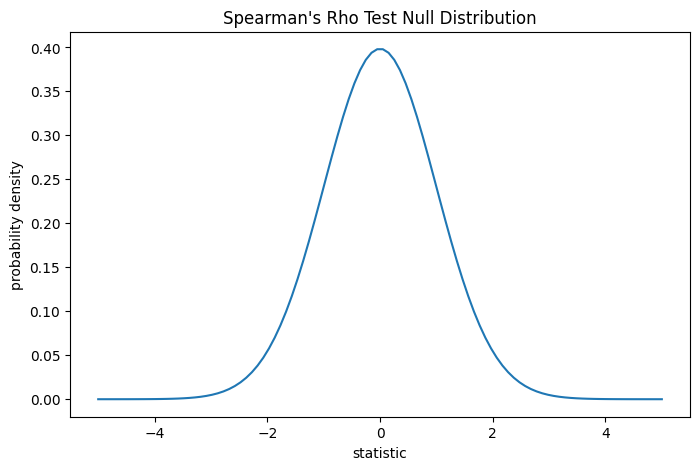

In [17]:
# We can transform the rho statistic so that it is theoretically distributed according to a
# distribution we know about, in this case Student's T distribution.

# First we draw the theoretical curve for the transformed stat.
dof = len(potter.UK) - 2  # strange DOF because of the transformation
dist = sp.stats.t(df=dof)
t_vals = np.linspace(-5, 5, 100)
pdf = dist.pdf(t_vals)
fig, ax = plt.subplots(figsize=(8, 5))


def plot(ax):  # we'll reuse this
    ax.plot(t_vals, pdf)
    ax.set_title("Spearman's Rho Test Null Distribution")
    ax.set_xlabel("statistic")
    ax.set_ylabel("probability density")


plot(ax)
plt.show()

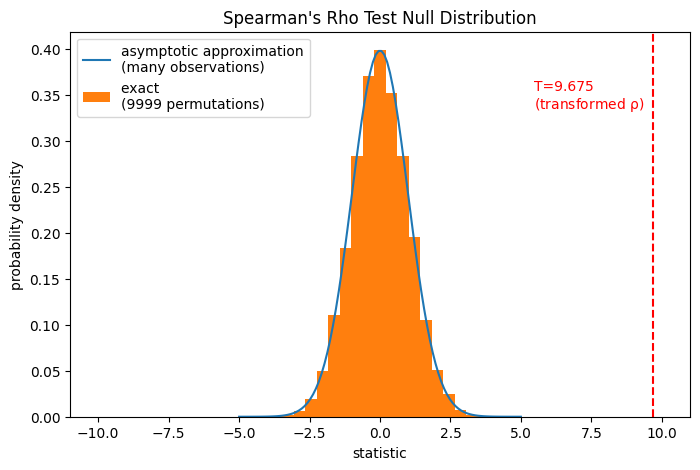

In [18]:
def statistic(x):
    # Explore many possible pairings by permuting `x`
    rs = sp.stats.spearmanr(x, potter.index).statistic
    # special transformation:
    transformed = rs * np.sqrt(dof / ((rs + 1.0) * (1.0 - rs)))
    return transformed


# reproducible results!
rng = np.random.default_rng(seed=42)

# It might seem weird that we are only permuting one element of the pairs, but it works out the same
# because Spearman's R doesn't care about order.
res = sp.stats.permutation_test(
    (potter.UK,),
    statistic,
    alternative="greater",
    permutation_type="pairings",
    n_resamples=9999,
    random_state=rng,
)
fig, ax = plt.subplots(figsize=(8, 5))
plot(ax)
ax.hist(res.null_distribution, np.linspace(-10, 10, 50), density=True)
ax.legend(
    [
        "asymptotic approximation\n(many observations)",
        f"exact \n({len(res.null_distribution)} permutations)",
    ]
)
trans = ax.get_xaxis_transform()  # lets us specify height by percentage
plt.text(
    res.statistic - 4.2,
    0.8,
    f"T={res.statistic.round(3)}\n(transformed $\\rho$)",
    color="red",
    transform=trans,
)
ax.axvline(res.statistic, linestyle="--", color="red")
plt.show()

In [19]:
# This is only this high because we only did 9999 simulations! If we had time to do many more it
# would approach the theoretical p-value from the analytic test.

res.pvalue

0.0001

<img src=https://imgs.xkcd.com/comics/correlation.png />

<small>XKCD, https://xkcd.com/552/ License CC-BY-NC 2.5</small>

```
Version History

Current: v1.0.1

3/10/24: 1.0.0: first draft, BN
09/10/24: 1.0.1: proofread, MK
```